# Context
Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds. However, not all chocolate bars are created equal! This dataset contains expert ratings of over 1,700 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown.

## Task
The purpose of this notebook is to create a model that will predict the quality of a bar. The target feature will be Rating. This will make the assumption that higher chocolate quality will translate to more sales; we will leave cost-benefit analysis to the manufacturing pipeline.

## Features
* Company: Name of company manufacturing the bar
* Specific Bean Origin: The specific geographical region of origin for the bar
* REF: A value linked to when the review was entered in the database. Higher = more recent.
* ReviewDate: Date of publication for review
* CocoaPercent: Cocoa percentage (darkness) of the chocolate bar being reviewed.
* CompanyLocation: Manufacturer base country
* Rating: Expert rating for the bar.
* BeanType: The variety/breed of the bean(s) used, if provided
* Broad BeanOrigin: The broad geographical region of origin for the bean

## Flavors of Cacao Rating System
(Quoted from dataset description)

* 5= Elite (Transcending beyond the ordinary limits)
* 4= Premium (Superior flavor development, character and style)
* 3= Satisfactory(3.0) to praiseworthy(3.75) (well made with special qualities)
* 2= Disappointing (Passable but contains at least one significant flaw)
* 1= Unpleasant (mostly unpalatable)

Each chocolate is evaluated from a combination of both objective qualities and subjective interpretation. A rating here only represents an experience with one bar from one batch. Batch numbers, vintages and review dates are included in the database when known.

The database is narrowly focused on plain dark chocolate with an aim of appreciating the flavors of the cacao when made into chocolate. The ratings do not reflect health benefits, social missions, or organic status.

Flavor is the most important component of the Flavors of Cacao ratings. Diversity, balance, intensity and purity of flavors are all considered. It is possible for a straight forward single note chocolate to rate as high as a complex flavor profile that changes throughout. Genetics, terroir, post harvest techniques, processing and storage can all be discussed when considering the flavor component.

Texture has a great impact on the overall experience and it is also possible for texture related issues to impact flavor. It is a good way to evaluate the makers vision, attention to detail and level of proficiency.

Aftermelt is the experience after the chocolate has melted. Higher quality chocolate will linger and be long lasting and enjoyable. Since the aftermelt is the last impression you get from the chocolate, it receives equal importance in the overall rating.

Overall Opinion is really where the ratings reflect a subjective opinion. Ideally it is my evaluation of whether or not the components above worked together and an opinion on the flavor development, character and style. It is also here where each chocolate can usually be summarized by the most prominent impressions that you would remember about each chocolate.


### Analysis Plan for each feature
* Company: This is categorical, and will need to be one hot encoded. Stored as a string.

* Bean Origin/Bar name: This is categorical, and will need to be one hot encoded. This data may be suspect, as it seems to be conflating two different data. Stored as a string.

* Review Year: This can be left as an integer. This might be interesting to reveal any review bias over time. Assume that any new chocolate we're gauging interest in came out in the present.

* Cocoa Percent: This is currently stored as a string. This will need to be converted to a float.

* Company Location: This is categorical, and will need to be one hot encoded. Stored as a string.

* Rating: The feature we are trying to predict. It looks like this data is not discretized to whole numbers (i.e., some of the results show 3.75 stars), meaning we will have to feature engineer this into buckets, or make this a regression model.

* Bean Type: This is categorical, and will need to be one hot encoded. We have some missing data. Stored as a string.

* Broad Bean Origin: This is categorical, and will need to be one hot encoded. We have some missing data. Stored as a string.

In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


/kaggle/input/chocolate-bar-ratings/flavors_of_cacao.csv


In [104]:
#imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.set_option('display.max_rows',100)

%matplotlib inline

# Load the data
data = pd.read_csv('/kaggle/input/chocolate-bar-ratings/flavors_of_cacao.csv')
# Rename the columns
data.rename(columns = {'Company\xa0\n(Maker-if known)':'company', 
                       'Specific Bean Origin\nor Bar Name':'bar_origin', 
                       'Review\nDate':'review_year',
                       'Cocoa\nPercent':'cocoa_percent',
                       'Company\nLocation':'company_location',
                       'Bean\nType':'bean_type',
                       'Broad Bean\nOrigin':'bean_origin'},
            inplace = True) 
data.index.name='id'
data.head()

,company,bar_origin,REF,review_year,cocoa_percent,company_location,Rating,bean_type,bean_origin
id,,,,,,,,,
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [105]:
# Functions I've written for various data cleaning tasks

def toPercent(string):
    # This function will convert a percentage string into a decimal variable
    # The purpose is to convert cocoa_percent into a numerical value
    return(float(string.strip('%'))/100)

def spaceToNan(datastring):
    # function to turn all cells with strings of one space character into a numpy null 
    # if the input is not a string, it will return the original input
    # if the input is not a single space, it will return the input
    # This is meant to clean the bean_type feature
    if type(datastring)==str:
        if datastring.strip() == '':
            return np.nan
        else:
            return datastring.strip()
    else:
        return datastring
    
def nanToUnknown(datastring):
    #function to turn all cells with the pandas null value into a string reading 'unknown'
    # as stated below, the purpose is to relabel null values of bean_type as unknown
    # this will allow us to use that feature to see if it is significant
    # This has to be run after spaceToNan above
    if pd.isna(datastring):
        return 'unknown'

    else:
        return datastring

After importing and renaming all the libraries above, we map a converter function to turn all of the cocoa percentages to a float. By definition, they will also be normalized.

In [106]:
#convert the cocoa percentage to a decimal float (try block to pass it if it's already been converted)
try:
    data['cocoa_percent']=data['cocoa_percent'].map(toPercent)
except(AttributeError):
    pass

# Convert any cells that are blank spaces to NaN values (mostly for bean_type)
data=data.applymap(spaceToNan)

data.head()

,company,bar_origin,REF,review_year,cocoa_percent,company_location,Rating,bean_type,bean_origin
id,,,,,,,,,
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,NaN,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,NaN,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,NaN,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,NaN,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,NaN,Peru


Now that we have made sure that our string data at least lists missing points correctly, let's see the quality of our data. 

In [107]:
print('Missing data')
print(data.isnull().sum())
print('\nUnique values')
print(data.nunique(dropna=False))

Missing data
company               0
bar_origin            0
REF                   0
review_year           0
cocoa_percent         0
company_location      0
Rating                0
bean_type           888
bean_origin          74
dtype: int64

Unique values
company              416
bar_origin          1039
REF                  440
review_year           12
cocoa_percent         45
company_location      60
Rating                13
bean_type             41
bean_origin          100
dtype: int64


This matches the description given by our source (https://www.kaggle.com/rtatman/chocolate-bar-ratings); so far we haven't caught any mistakes they missed. 74 bars are missing the bean origin, about 4%. We will probably be able to drop those without too much issue. 888 data points are missing the bean type, however, which is too much to ignore. We could drop that column, but it seems a shame to lose that feature. If we assume that Bean Type and Bean origin represents what the critics knew (and not data displacement on the part of the aggregator), we can replace these missing data with "unknown", and then keep the data. This will let us see if knowledge of those features are affecting the review.

In [108]:
data_unknowns=data.applymap(nanToUnknown)
data_unknowns.head()

,company,bar_origin,REF,review_year,cocoa_percent,company_location,Rating,bean_type,bean_origin
id,,,,,,,,,
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,unknown,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,unknown,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,unknown,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,unknown,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,unknown,Peru


#### Checking the Cocoa Percent Distribution
Despite having over a thousand data points, I don't think chocolate manufacturers are coming up with a new cocoa ratio every bar. I ran a quick list of the unique values in that column to make sure that there wouldn't be any weird gaps in the distribution if I ran a finer histogram. Satisfied, I plotted the data with 10 buckets, and confirmed that it looks relatively normal. Furthermore, it looks like this column is complete (no missing data).

[0.42  0.46  0.5   0.53  0.55  0.56  0.57  0.58  0.6   0.605 0.61  0.62
 0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71  0.72  0.725 0.73
 0.735 0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83  0.84
 0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.99  1.   ]


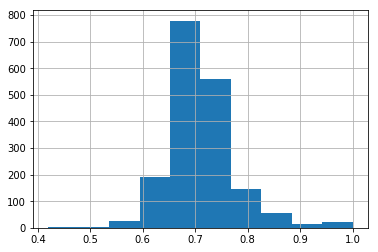

In [109]:
print(np.sort(data_unknowns['cocoa_percent'].unique()))
n_bins=10
data_unknowns['cocoa_percent'].hist(bins=n_bins)

#### Checking Categorical data
Next, we look at the range of values for company location, bean origin, and bean type. Company location seems straightforward, but we see that the bean type lists blends as well. It may be best to fuse similar categories here. In addition, some of the bars seem to have their beans sourced from many different locations.

In [110]:
print(data_unknowns['company_location'].unique())
print(data_unknowns['bean_origin'].unique())
print(data_unknowns['bean_type'].unique())

['France' 'U.S.A.' 'Fiji' 'Ecuador' 'Mexico' 'Switzerland' 'Netherlands'
 'Spain' 'Peru' 'Canada' 'Italy' 'Brazil' 'U.K.' 'Australia' 'Wales'
 'Belgium' 'Germany' 'Russia' 'Puerto Rico' 'Venezuela' 'Colombia' 'Japan'
 'New Zealand' 'Costa Rica' 'South Korea' 'Amsterdam' 'Scotland'
 'Martinique' 'Sao Tome' 'Argentina' 'Guatemala' 'South Africa' 'Bolivia'
 'St. Lucia' 'Portugal' 'Singapore' 'Denmark' 'Vietnam' 'Grenada' 'Israel'
 'India' 'Czech Republic' 'Domincan Republic' 'Finland' 'Madagascar'
 'Philippines' 'Sweden' 'Poland' 'Austria' 'Honduras' 'Nicaragua'
 'Lithuania' 'Niacragua' 'Chile' 'Ghana' 'Iceland' 'Eucador' 'Hungary'
 'Suriname' 'Ireland']
['Sao Tome' 'Togo' 'Peru' 'Venezuela' 'Cuba' 'Panama' 'Madagascar'
 'Brazil' 'Ecuador' 'Colombia' 'Burma' 'Papua New Guinea' 'Bolivia' 'Fiji'
 'Mexico' 'Indonesia' 'Trinidad' 'Vietnam' 'Nicaragua' 'Tanzania'
 'Dominican Republic' 'Ghana' 'Belize' 'unknown' 'Jamaica' 'Grenada'
 'Guatemala' 'Honduras' 'Costa Rica' 'Domincan Republic' 'Haiti

#### Checking Bean types
The bean types clearly have some beans that are more common than others. Some show exactly which beans are in there, some show only there's a blend but not of which beans, and some even have percentages. Due to the varying amount of detail, this feature needs to be simplified. Again, this is the feature missing about 50% of its data.

After doing some research, it looks like there are three main types of cacao beans: Criollo, Forastero, and Trinitario. There are also a fair number of blends of these three types. We recode into a smaller number of categories with the assumption that the subvarieties are less important discriminators.

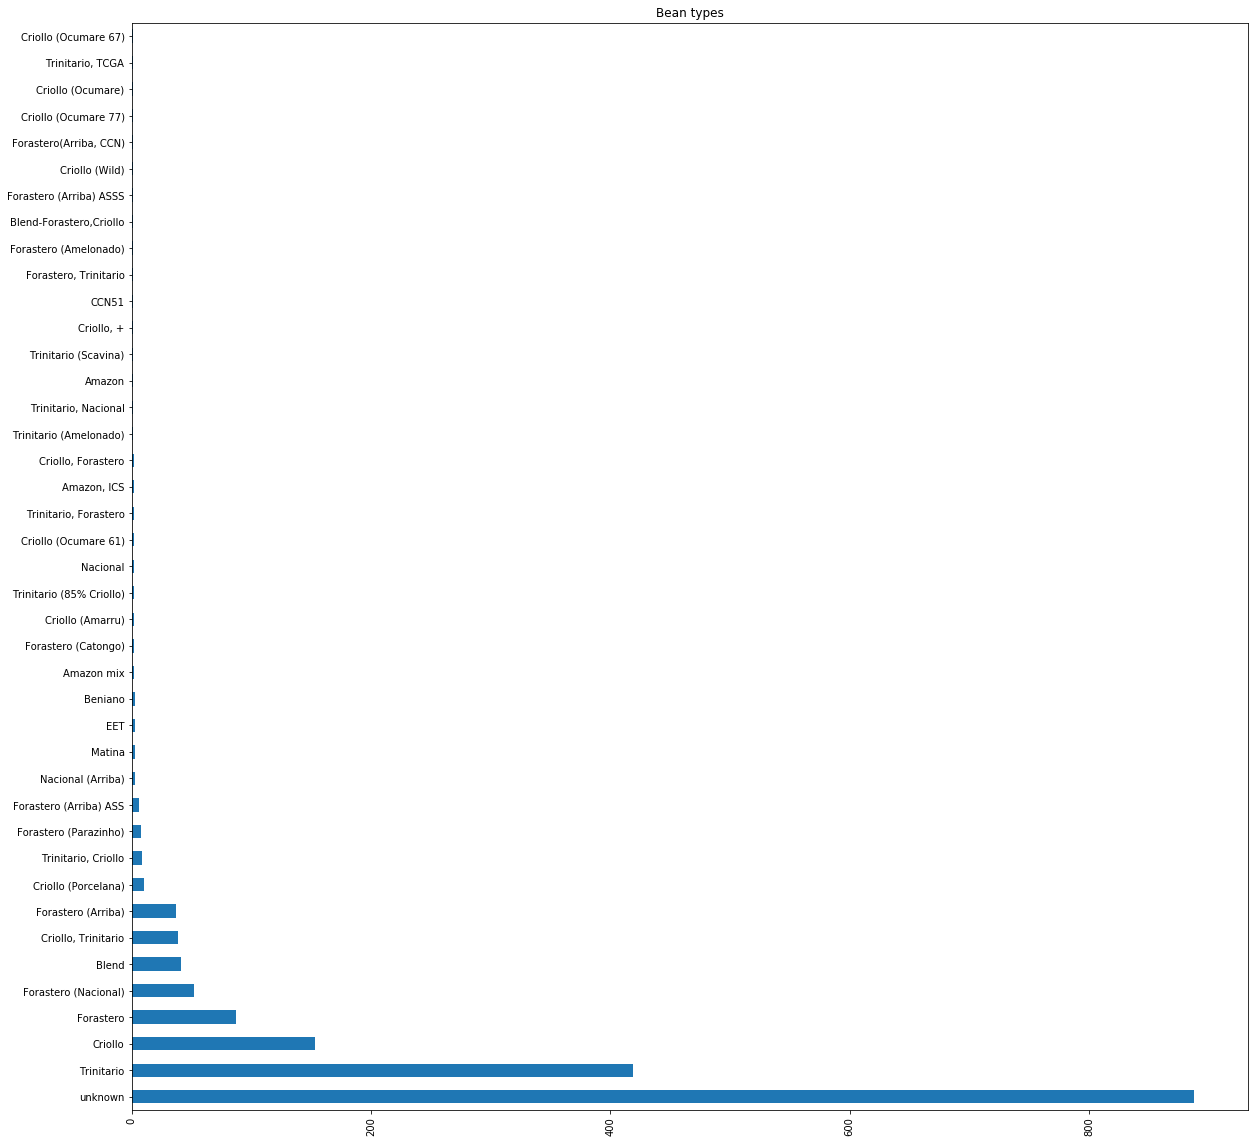

In [111]:
plt.figure(figsize=(20,20))
data_unknowns['bean_type'].value_counts().plot(kind='barh')
plt.xticks(rotation=90);
plt.title("Bean types");

In [112]:
def collapse_bean_type(bean):
    if bean == 'unknown':
        label = 'unknown'
    elif 'blend' in bean.lower() or ('forasetero' in bean.lower() and 'criollo' in bean.lower()) or ('forasetero' in bean.lower() and 'trinitario' in bean.lower()):
        label = 'blend'
    elif 'forasetero' in bean.lower():
        label = 'forasetero'
    elif 'criollo' in bean.lower():
        label = 'criollo'
    elif 'trinitario' in bean.lower():
        label = 'trinitario'
    else:
        label = 'other'
    return label

In [113]:
data_unknowns['bean_type'] = data_unknowns['bean_type'].apply(collapse_bean_type)
data_unknowns

,company,bar_origin,REF,review_year,cocoa_percent,company_location,Rating,bean_type,bean_origin
id,,,,,,,,,
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,unknown,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,unknown,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,unknown,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,unknown,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,unknown,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,0.70,Austria,3.75,unknown,Peru
1791,Zotter,Congo,749,2011,0.65,Austria,3.00,other,Congo
1792,Zotter,Kerala State,749,2011,0.65,Austria,3.50,other,India


#### Bean Origin
The bean origin is heavily biased towards a few countries. Some of the entries with multiple countries could probably be fused with a more common country, or this could become a categorization vector that could show multiple values.

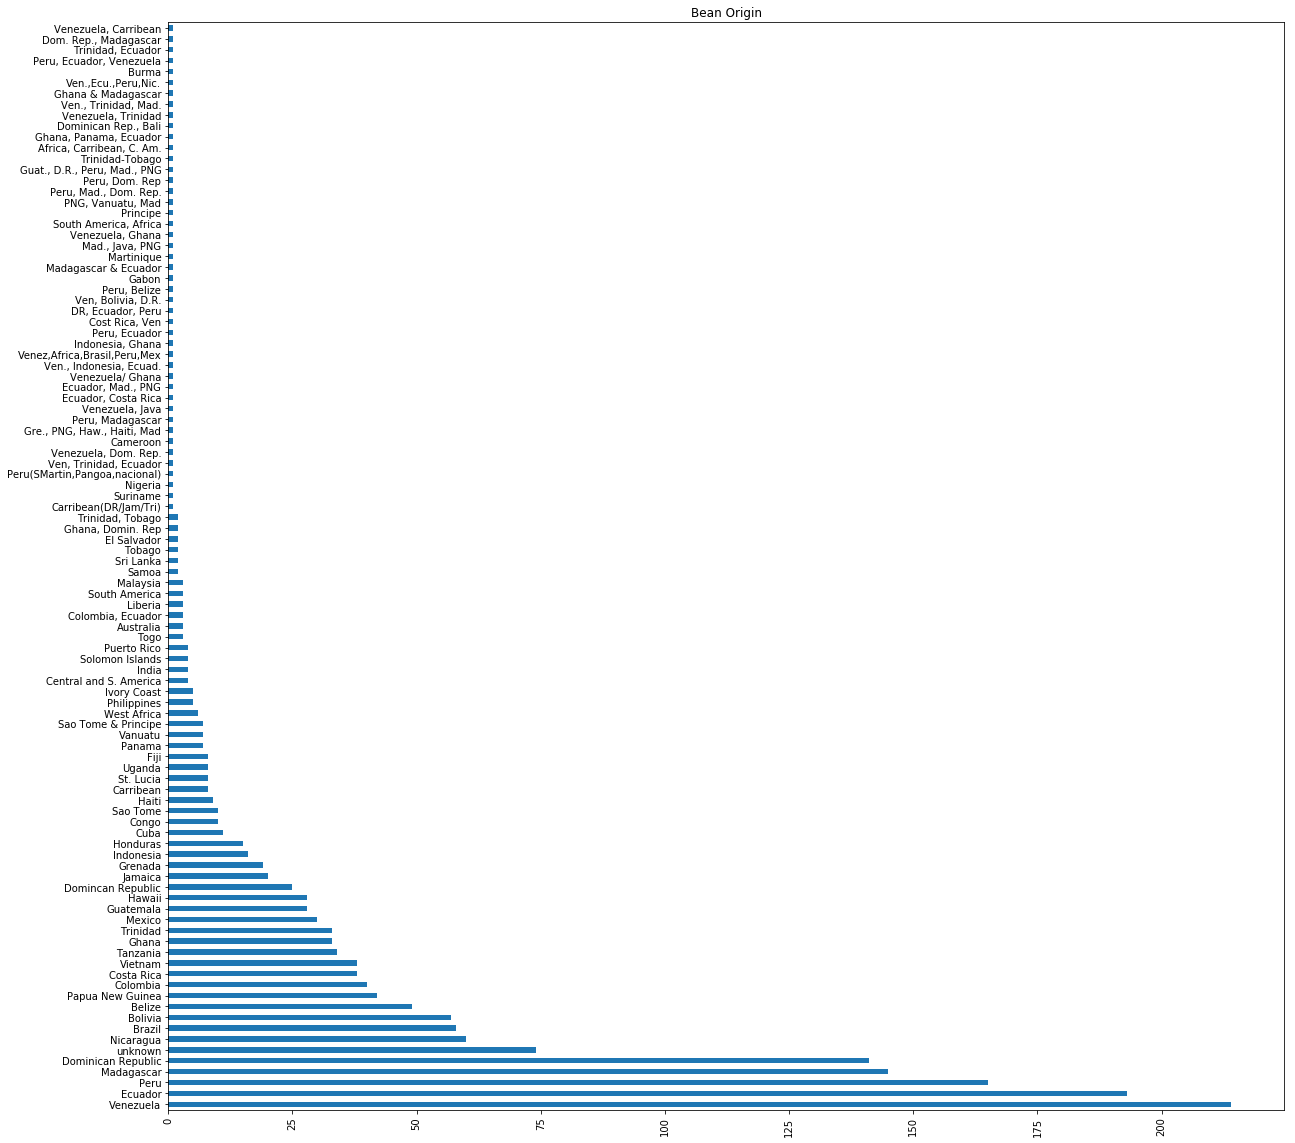

In [114]:
plt.figure(figsize=(20,20))
data_unknowns['bean_origin'].value_counts().plot(kind='barh')
plt.xticks(rotation=90);
plt.title("Bean Origin");

In [136]:
data_unknowns.head()

,company,bar_origin,review_year,cocoa_percent,company_location,Rating,bean_type,bean_origin
id,,,,,,,,
0,A. Morin,Agua Grande,2016,0.63,France,3.75,unknown,Sao Tome
1,A. Morin,Kpime,2015,0.70,France,2.75,unknown,Togo
2,A. Morin,Atsane,2015,0.70,France,3.00,unknown,Togo
3,A. Morin,Akata,2015,0.70,France,3.50,unknown,Togo
4,A. Morin,Quilla,2015,0.70,France,3.50,unknown,Peru


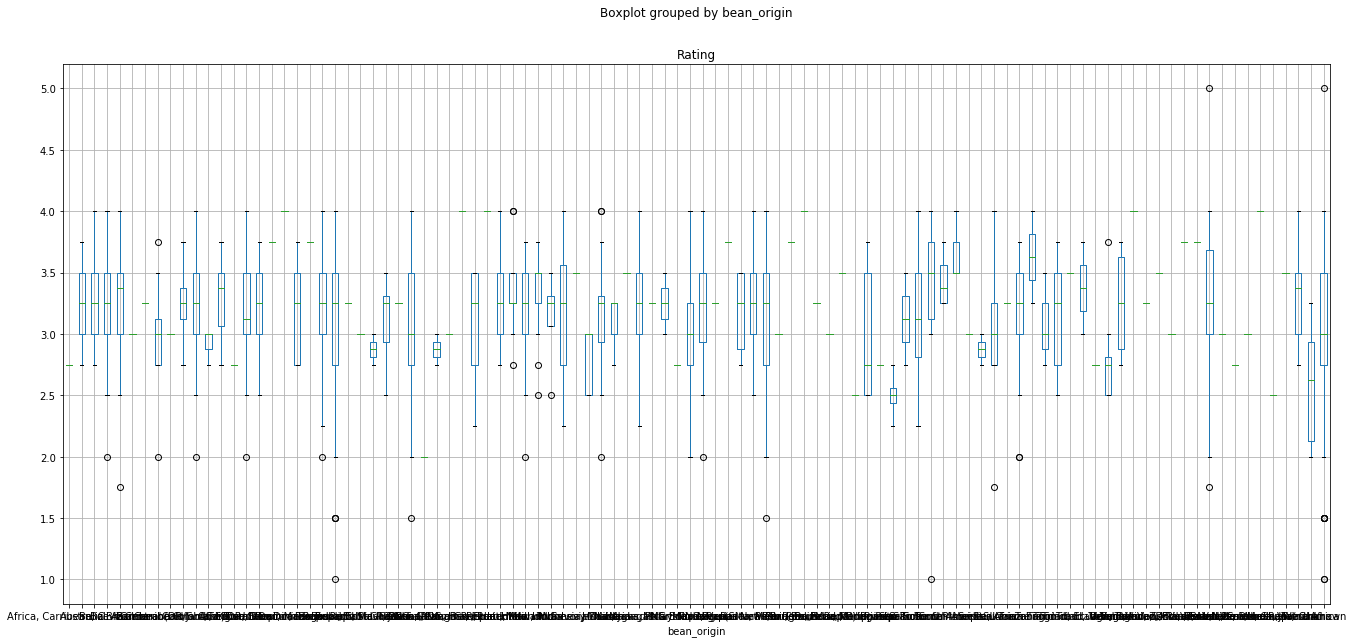

In [144]:
data_unknowns.boxplot(by='bean_origin', column='Rating', figsize=(22, 10))

In [115]:
# I'm not sure what REF is, but here we can prove that it's not just a data index
data_unknowns.pivot_table(index=['REF'], aggfunc='size')

REF
5       4
15      6
24      9
32      8
40      6
       ..
1936    4
1940    4
1944    4
1948    4
1952    3
Length: 440, dtype: int64

In [116]:
# So we drop it
data_unknowns = data_unknowns.drop(columns=['REF'])

# Model setup

Get a MSE baseline using the mean of various training sets to predict the test set.

In [124]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [123]:
X = data_unknowns[[col for col in data_unknowns.columns if col != 'Rating']]
y = data_unknowns['Rating']

In [130]:
cv = KFold(n_splits=5)
mses = []
for train_index, test_index in cv.split(X, y):
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    y_mean = y_train.mean()
    y_pred = y_test.copy()
    y_pred.loc[:] = y_mean
    mses.append(mean_squared_error(y_test, y_pred))
print(np.mean(mses))

0.22908551541732294


In [117]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [132]:
data_unknowns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 8 columns):
company             1795 non-null object
bar_origin          1795 non-null object
review_year         1795 non-null int64
cocoa_percent       1795 non-null float64
company_location    1795 non-null object
Rating              1795 non-null float64
bean_type           1795 non-null object
bean_origin         1795 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 112.3+ KB


In [133]:
data_unknowns_dumm = pd.get_dummies(data_unknowns)
data_unknowns_dumm

,review_year,cocoa_percent,Rating,company_A. Morin,company_AMMA,company_Acalli,company_Adi,company_Aequare (Gianduja),company_Ah Cacao,company_Akesson's (Pralus),...,bean_origin_Venezuela,"bean_origin_Venezuela, Carribean","bean_origin_Venezuela, Dom. Rep.","bean_origin_Venezuela, Ghana","bean_origin_Venezuela, Java","bean_origin_Venezuela, Trinidad",bean_origin_Venezuela/ Ghana,bean_origin_Vietnam,bean_origin_West Africa,bean_origin_unknown
id,,,,,,,,,,,,,,,,,,,,,
0,2016,0.63,3.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,0.70,2.75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,0.70,3.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015,0.70,3.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,0.70,3.50,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,2011,0.70,3.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1791,2011,0.65,3.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1792,2011,0.65,3.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
mses_rf = []
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.loc[train_index], y.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    rfr = RandomForestRegressor(n_estimators=100, max_depth=None)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mses_rf.append(mean_squared_error(y_test, y_pred))
print(mses_rf)

ValueError: could not convert string to float: 'Castronovo'

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)